## Predicting the Dow Jones Index using News Headline
This notebook is split into two sections:
The first section is data import, exploration, and error resolution.
The second section is model selection and optimization.

In [1]:
#Import Statements
import pandas as pd
import numpy as np
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Importing the data
news_df = pd.read_csv("combined_stock_data.csv", parse_dates=[1])

In [4]:
news_df.head(2)

,Unnamed: 0,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top22,Top23,Top24,Top25,Para,Subjectivity,Objectivity,Positive,Neutral,Negative
0,0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",75.000000,25.000000,18.750000,25.000000,56.250000
1,1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,83.333333,16.666667,41.666667,16.666667,41.666667


In [5]:
# Load the stock prices Dow Jones dataset into a dataframe
prices_df = "DJIA_table.csv"
stocks_df = pd.read_csv(prices_df, parse_dates=[0])
stocks_df.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688


In [6]:
# Create a dataframe by merging the headlines and the stock prices dataframe
combined_news_stock = news_df[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(stocks_df, how='inner', on='Date', left_index=True)
combined_news_stock.head()

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,1,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,0,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [7]:
combined_news_stock.shape

(1989, 13)

In [8]:
#Conver Volume to float
combined_news_stock['Volume'] = combined_news_stock['Volume'].astype(float)
combined_news_stock.index = combined_news_stock.index.sort_values()
combined_news_stock.head(2)

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312
1,2008-08-11,1,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609


In [9]:
combined_news_stock.describe()

,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
count,1989.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000
mean,0.535445,56.712522,43.287478,19.966718,36.745804,43.287478,13459.116048,13541.303173,13372.931728,13463.032255,1.628110e+08,13463.032255
std,0.498867,21.557927,21.557927,16.373424,21.109970,21.557927,3143.281634,3136.271725,3150.420934,3144.006996,9.392343e+07,3144.006996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,6547.049805
25%,0.000000,40.000000,28.571429,8.333333,21.859903,28.571429,10907.339844,11000.980469,10824.759766,10913.379883,1.000000e+08,10913.379883
50%,1.000000,54.545455,45.454545,18.181818,33.333333,45.454545,13022.049805,13088.110352,12953.129883,13025.580078,1.351700e+08,13025.580078
75%,1.000000,71.428571,60.000000,28.571429,50.000000,60.000000,16477.699219,16550.070312,16392.769531,16478.410156,1.926000e+08,16478.410156
max,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,18312.390625


### Date Shift
Shifting the data one row down compared to the Label we are trying to predict so that we are predicting the next day using features from the previous day

In [10]:
df = combined_news_stock

In [11]:
df.head()

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312
1,2008-08-11,1,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609
2,2008-08-12,0,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727
3,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961
4,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1989 entries, 0 to 1988
Data columns (total 13 columns):
Date            1989 non-null datetime64[ns]
Label           1989 non-null int64
Subjectivity    1986 non-null float64
Objectivity     1986 non-null float64
Positive        1986 non-null float64
Negative        1986 non-null float64
Neutral         1986 non-null float64
Open            1989 non-null float64
High            1989 non-null float64
Low             1989 non-null float64
Close           1989 non-null float64
Volume          1989 non-null float64
Adj Close       1989 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 217.5 KB


In [13]:
df.sort_values(by = 'Date', ascending = False, inplace = True)
df.head()

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
1988,2016-07-01,1,60.000000,40.000000,0.000000,60.000000,40.000000,17924.240234,18002.380859,17916.910156,17949.369141,82160000.0,17949.369141
1987,2016-06-30,1,100.000000,0.000000,100.000000,0.000000,0.000000,17712.759766,17930.609375,17711.800781,17929.990234,133030000.0,17929.990234
1986,2016-06-29,1,80.000000,20.000000,0.000000,80.000000,20.000000,17456.019531,17704.509766,17456.019531,17694.679688,106380000.0,17694.679688
1985,2016-06-28,1,42.857143,57.142857,0.000000,42.857143,57.142857,17190.509766,17409.720703,17190.509766,17409.720703,112190000.0,17409.720703
1984,2016-06-27,0,33.333333,66.666667,16.666667,16.666667,66.666667,17355.210938,17355.210938,17063.080078,17140.240234,138740000.0,17140.240234


In [14]:
dft = df[['Date','Label']]
dft.head()

,Date,Label
1988,2016-07-01,1
1987,2016-06-30,1
1986,2016-06-29,1
1985,2016-06-28,1
1984,2016-06-27,0


In [15]:
dft = dft.append({'Date' : datetime.strptime('01 August, 2016',"%d %B, %Y") , 'Label' : 2} , ignore_index=True)

In [16]:
dft=dft.sort_values(by='Date', ascending =False).reset_index()
dft.head()

,index,Date,Label
0,1989,2016-08-01,2
1,0,2016-07-01,1
2,1,2016-06-30,1
3,2,2016-06-29,1
4,3,2016-06-28,1


In [17]:
dff=df[["Date","Subjectivity","Objectivity","Positive","Negative","Neutral","Open","High","Low","Close","Volume","Adj Close"]].reset_index().rename(columns={"Date": "Date2"})
dff.shape

(1989, 13)

In [18]:
df2=dft.merge(right = dff, left_index = True, right_index = True)
df2.head(5)

,index_x,Date,Label,index_y,Date2,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
0,1989,2016-08-01,2,1988,2016-07-01,60.000000,40.000000,0.000000,60.000000,40.000000,17924.240234,18002.380859,17916.910156,17949.369141,82160000.0,17949.369141
1,0,2016-07-01,1,1987,2016-06-30,100.000000,0.000000,100.000000,0.000000,0.000000,17712.759766,17930.609375,17711.800781,17929.990234,133030000.0,17929.990234
2,1,2016-06-30,1,1986,2016-06-29,80.000000,20.000000,0.000000,80.000000,20.000000,17456.019531,17704.509766,17456.019531,17694.679688,106380000.0,17694.679688
3,2,2016-06-29,1,1985,2016-06-28,42.857143,57.142857,0.000000,42.857143,57.142857,17190.509766,17409.720703,17190.509766,17409.720703,112190000.0,17409.720703
4,3,2016-06-28,1,1984,2016-06-27,33.333333,66.666667,16.666667,16.666667,66.666667,17355.210938,17355.210938,17063.080078,17140.240234,138740000.0,17140.240234


## Adding Features for Stock Data
Adding additional features for stock price movement

In [19]:
df2['change_yest']=0
df2['change_2day']=0
df2['change_3day']=0
df2['change_7day']=0
df2['change_14day']=0
df2['change_2day_Trend']=0
df2['change_3day_Trend']=0
#df2['change_21day']=0
#df2['change_28day']=0
df2.head()

,index_x,Date,Label,index_y,Date2,Subjectivity,Objectivity,Positive,Negative,Neutral,...,Close,Volume,Adj Close,change_yest,change_2day,change_3day,change_7day,change_14day,change_2day_Trend,change_3day_Trend
0,1989,2016-08-01,2,1988,2016-07-01,60.000000,40.000000,0.000000,60.000000,40.000000,...,17949.369141,82160000.0,17949.369141,0,0,0,0,0,0,0
1,0,2016-07-01,1,1987,2016-06-30,100.000000,0.000000,100.000000,0.000000,0.000000,...,17929.990234,133030000.0,17929.990234,0,0,0,0,0,0,0
2,1,2016-06-30,1,1986,2016-06-29,80.000000,20.000000,0.000000,80.000000,20.000000,...,17694.679688,106380000.0,17694.679688,0,0,0,0,0,0,0
3,2,2016-06-29,1,1985,2016-06-28,42.857143,57.142857,0.000000,42.857143,57.142857,...,17409.720703,112190000.0,17409.720703,0,0,0,0,0,0,0
4,3,2016-06-28,1,1984,2016-06-27,33.333333,66.666667,16.666667,16.666667,66.666667,...,17140.240234,138740000.0,17140.240234,0,0,0,0,0,0,0


In [20]:
for index, row in df2.iterrows():
    if index<1988:
        df2.iloc[index,16] = df2.iloc[index,11]-df2.iloc[index+1,11]
        
    if index<1987:
        df2.iloc[index,17] = df2.iloc[index,11]-df2.iloc[index+2,11]
        df2.iloc[index,21] = df2.iloc[index+1,11]-df2.iloc[index+2,11]
        
    if index<1986:
        df2.iloc[index,18] = df2.iloc[index,11]-df2.iloc[index+3,11]
        df2.iloc[index,22] = df2.iloc[index+2,11]-df2.iloc[index+3,11]
    
    if index<1981:
        df2.iloc[index,19] = df2.iloc[index,11]-df2.iloc[index+7,11]      
        
    if index<1975:
        df2.iloc[index,20] = df2.iloc[index,11]-df2.iloc[index+14,11]

#    if index<1968:
#        df2.iloc[index,23] = df2.iloc[index,11]-df2.iloc[index+21,11]
        
#    if index<1961:
#        df2.iloc[index,24] = df2.iloc[index,11]-df2.iloc[index+28,11]

In [21]:
df2.head()

,index_x,Date,Label,index_y,Date2,Subjectivity,Objectivity,Positive,Negative,Neutral,...,Close,Volume,Adj Close,change_yest,change_2day,change_3day,change_7day,change_14day,change_2day_Trend,change_3day_Trend
0,1989,2016-08-01,2,1988,2016-07-01,60.000000,40.000000,0.000000,60.000000,40.000000,...,17949.369141,82160000.0,17949.369141,71.771484,297.871093,592.660156,82.220703,109.101562,226.099609,294.789063
1,0,2016-07-01,1,1987,2016-06-30,100.000000,0.000000,100.000000,0.000000,0.000000,...,17929.990234,133030000.0,17929.990234,226.099609,520.888672,575.398437,52.769531,-8.210937,294.789063,54.509765
2,1,2016-06-30,1,1986,2016-06-29,80.000000,20.000000,0.000000,80.000000,20.000000,...,17694.679688,106380000.0,17694.679688,294.789063,349.298828,-242.121093,-241.849609,-300.710937,54.509765,-591.419921
3,2,2016-06-29,1,1985,2016-06-28,42.857143,57.142857,0.000000,42.857143,57.142857,...,17409.720703,112190000.0,17409.720703,54.509765,-536.910156,-601.349609,-323.718750,-606.279297,-591.419921,-64.439453
4,3,2016-06-28,1,1984,2016-06-27,33.333333,66.666667,16.666667,16.666667,66.666667,...,17140.240234,138740000.0,17140.240234,-591.419921,-655.859374,-564.949218,-399.699218,-648.019531,-64.439453,90.910156


In [22]:
df2.shape

(1989, 23)

In [23]:
df2.drop(columns=['index_x','Date','index_y','Date2'], inplace = True)

In [24]:
df2.head()

,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,change_yest,change_2day,change_3day,change_7day,change_14day,change_2day_Trend,change_3day_Trend
0,2,60.000000,40.000000,0.000000,60.000000,40.000000,17924.240234,18002.380859,17916.910156,17949.369141,82160000.0,17949.369141,71.771484,297.871093,592.660156,82.220703,109.101562,226.099609,294.789063
1,1,100.000000,0.000000,100.000000,0.000000,0.000000,17712.759766,17930.609375,17711.800781,17929.990234,133030000.0,17929.990234,226.099609,520.888672,575.398437,52.769531,-8.210937,294.789063,54.509765
2,1,80.000000,20.000000,0.000000,80.000000,20.000000,17456.019531,17704.509766,17456.019531,17694.679688,106380000.0,17694.679688,294.789063,349.298828,-242.121093,-241.849609,-300.710937,54.509765,-591.419921
3,1,42.857143,57.142857,0.000000,42.857143,57.142857,17190.509766,17409.720703,17190.509766,17409.720703,112190000.0,17409.720703,54.509765,-536.910156,-601.349609,-323.718750,-606.279297,-591.419921,-64.439453
4,1,33.333333,66.666667,16.666667,16.666667,66.666667,17355.210938,17355.210938,17063.080078,17140.240234,138740000.0,17140.240234,-591.419921,-655.859374,-564.949218,-399.699218,-648.019531,-64.439453,90.910156


In [25]:
df2.drop(index=0, inplace = True)
df2.head()

,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,change_yest,change_2day,change_3day,change_7day,change_14day,change_2day_Trend,change_3day_Trend
1,1,100.000000,0.000000,100.000000,0.000000,0.000000,17712.759766,17930.609375,17711.800781,17929.990234,133030000.0,17929.990234,226.099609,520.888672,575.398437,52.769531,-8.210937,294.789063,54.509765
2,1,80.000000,20.000000,0.000000,80.000000,20.000000,17456.019531,17704.509766,17456.019531,17694.679688,106380000.0,17694.679688,294.789063,349.298828,-242.121093,-241.849609,-300.710937,54.509765,-591.419921
3,1,42.857143,57.142857,0.000000,42.857143,57.142857,17190.509766,17409.720703,17190.509766,17409.720703,112190000.0,17409.720703,54.509765,-536.910156,-601.349609,-323.718750,-606.279297,-591.419921,-64.439453
4,1,33.333333,66.666667,16.666667,16.666667,66.666667,17355.210938,17355.210938,17063.080078,17140.240234,138740000.0,17140.240234,-591.419921,-655.859374,-564.949218,-399.699218,-648.019531,-64.439453,90.910156
5,0,50.000000,50.000000,33.333333,16.666667,50.000000,17946.630859,17946.630859,17356.339844,17400.750000,239000000.0,17400.750000,-64.439453,26.470703,68.791015,183.669921,-3.048829,90.910156,42.320312


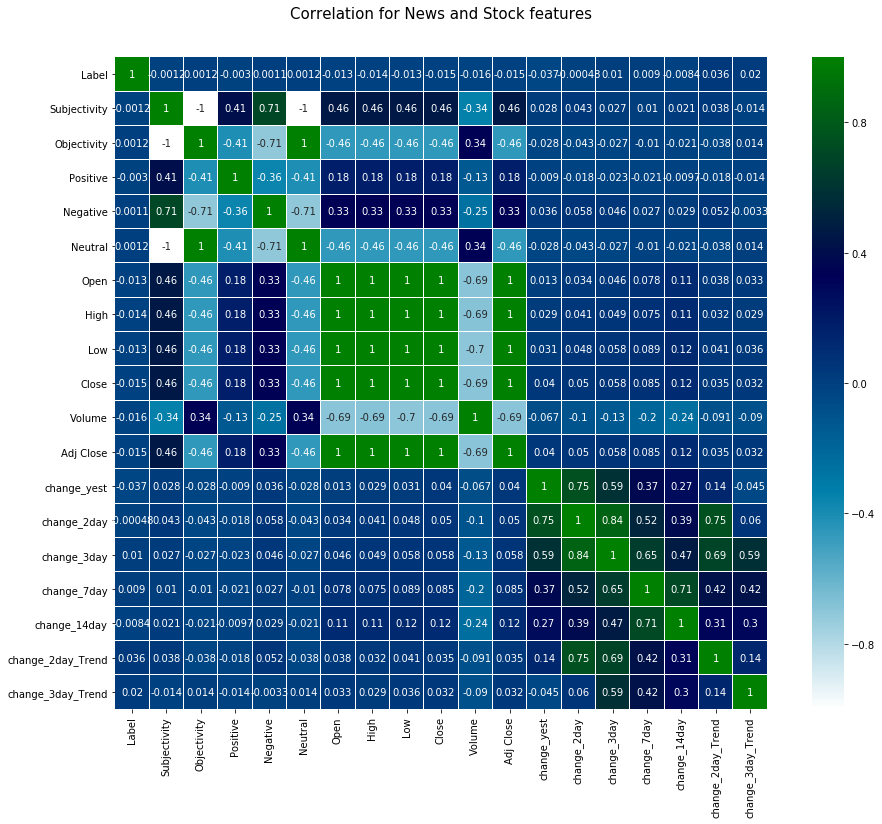

In [26]:
df3=df2 #Creating a data set for our pipeline experimentation below
colormap = pyplot.cm.ocean_r
pyplot.figure(figsize=(16,12))
pyplot.title('Correlation for News and Stock features', y=1.05, size=15)
sns.heatmap(df2.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

In [27]:
df2.drop(columns=['Objectivity','Neutral','Open','High','Low','Close'], inplace = True)

In [28]:
df2.head()

,Label,Subjectivity,Positive,Negative,Volume,Adj Close,change_yest,change_2day,change_3day,change_7day,change_14day,change_2day_Trend,change_3day_Trend
1,1,100.000000,100.000000,0.000000,133030000.0,17929.990234,226.099609,520.888672,575.398437,52.769531,-8.210937,294.789063,54.509765
2,1,80.000000,0.000000,80.000000,106380000.0,17694.679688,294.789063,349.298828,-242.121093,-241.849609,-300.710937,54.509765,-591.419921
3,1,42.857143,0.000000,42.857143,112190000.0,17409.720703,54.509765,-536.910156,-601.349609,-323.718750,-606.279297,-591.419921,-64.439453
4,1,33.333333,16.666667,16.666667,138740000.0,17140.240234,-591.419921,-655.859374,-564.949218,-399.699218,-648.019531,-64.439453,90.910156
5,0,50.000000,33.333333,16.666667,239000000.0,17400.750000,-64.439453,26.470703,68.791015,183.669921,-3.048829,90.910156,42.320312


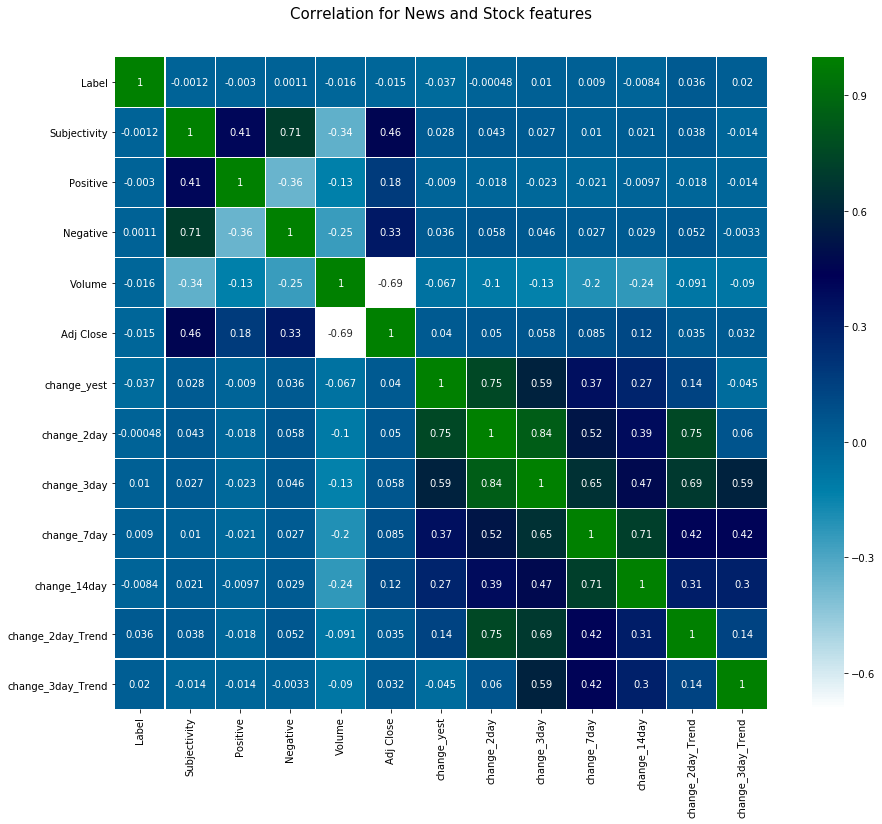

In [29]:
colormap = pyplot.cm.ocean_r
pyplot.figure(figsize=(16,12))
pyplot.title('Correlation for News and Stock features', y=1.05, size=15)
sns.heatmap(df2.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

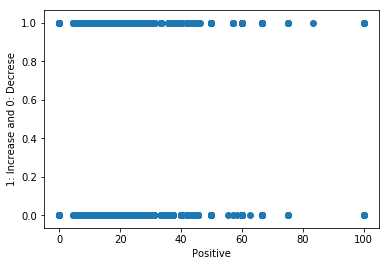

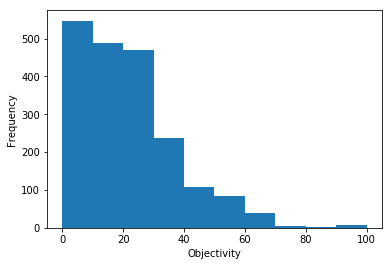

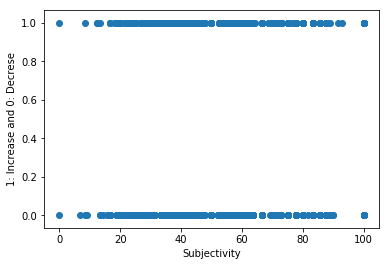

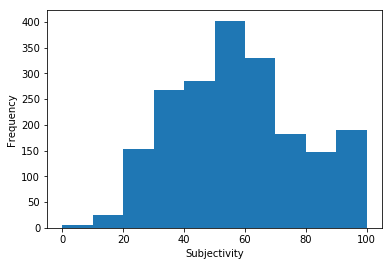

In [30]:
pyplot.scatter(df2['Positive'], df2['Label'])
pyplot.xlabel('Positive')
pyplot.ylabel('1: Increase and 0: Decrese')
pyplot.show()
df2['Positive'].plot('hist')
pyplot.xlabel('Objectivity')
pyplot.ylabel('Frequency')
pyplot.show()
pyplot.scatter(df2['Subjectivity'], df2['Label'])
pyplot.xlabel('Subjectivity')
pyplot.ylabel('1: Increase and 0: Decrese')
pyplot.show()
df2['Subjectivity'].plot('hist')
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Frequency')
pyplot.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000152AEA58>,
      dtype=object)

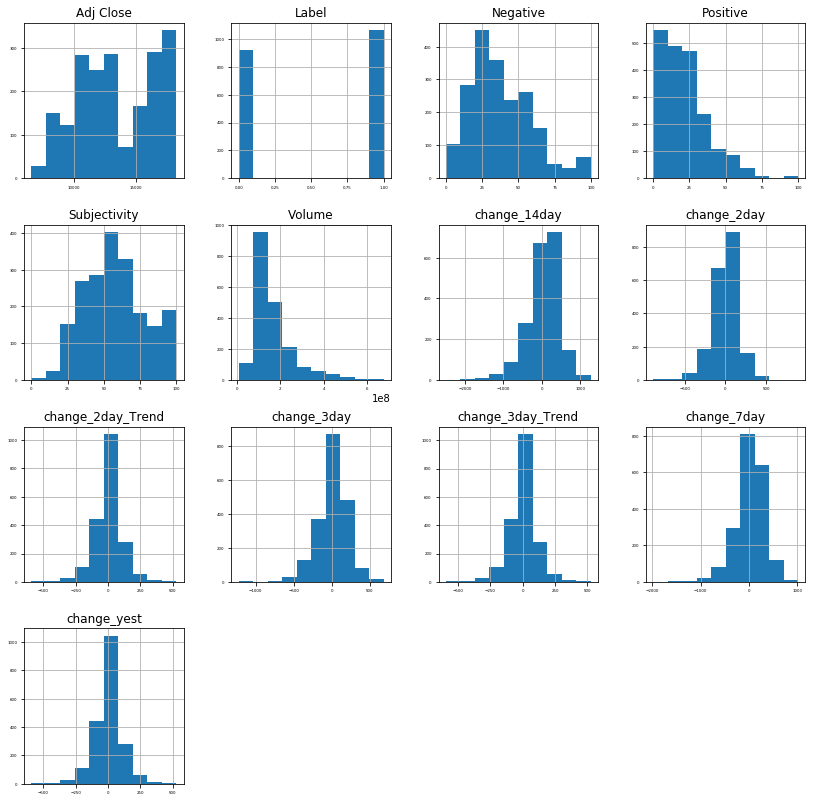

In [31]:
df2.hist(xlabelsize = 4, ylabelsize = 4, figsize=(14, 14))

#### Machine learning - Model selection

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [33]:
# Impute NaN values to the mean value of that column
list_NaN = ["Subjectivity","Positive","Negative","Volume","Adj Close"]
for col in list_NaN:
    df2[col] = df2[col].fillna(df2[col].mean())

# Split the dataframe for Labels and Target
X = df2.loc[:,'Subjectivity':'change_3day_Trend']
y = df2.loc[:,'Label']

# Split the dataset to test and train sets with 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scoring = 'accuracy'

models = []
models.append(('RF' , RandomForestClassifier(n_estimators=100)))
models.append(('ADB' , AdaBoostClassifier(n_estimators=100)))
models.append(('GBC' , GradientBoostingClassifier(n_estimators=100)))
models.append(('DTC' , DecisionTreeClassifier()))
models.append(('SVC' , SVC()))
models.append(('LR' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))

In [34]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [35]:
# Evaluate each algorithm for accuracy
results = []
names = []
for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

RF: 0.5125628140703518
ADB: 0.5393634840871022
GBC: 0.5360134003350083
DTC: 0.5058626465661642
SVC: 0.5343383584589615
LR: 0.5527638190954773
KNN: 0.509212730318258


### Adaboost, Gradient Boost, Decision Tree, RandomForest and Logistic Regression for further analysis

In [36]:
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [37]:
# AdaBoostClassifier
model_adb = AdaBoostClassifier(n_estimators=1000)
model_adb.fit(X_scaled, y_train)
X_testScaled = scaler.transform(X_test)
predictions = model_adb.predict(X_testScaled)
print("\n Accuracy score:" + str(accuracy_score(y_test, predictions)))
print("\n Confusion matrix: " + str(confusion_matrix(y_test, predictions)))
print("\n Accuracy Report: \n\t" + str(classification_report(y_test, predictions)))


 Accuracy score:0.49581239530988275

 Confusion matrix: [[111 167]
 [134 185]]

 Accuracy Report: 
	             precision    recall  f1-score   support

          0       0.45      0.40      0.42       278
          1       0.53      0.58      0.55       319

avg / total       0.49      0.50      0.49       597



In [38]:
# Gradient Boost Classifier
model_gbc = GradientBoostingClassifier(n_estimators=1000)
model_gbc.fit(X_scaled, y_train)
X_testScaled = scaler.transform(X_test)
predictions = model_gbc.predict(X_testScaled)
print("\n Accuracy score:" + str(accuracy_score(y_test, predictions)))
print("\n Confusion matrix: " + str(confusion_matrix(y_test, predictions)))
print("\n Accuracy Report: \n\t" + str(classification_report(y_test, predictions)))


 Accuracy score:0.5142378559463987

 Confusion matrix: [[118 160]
 [130 189]]

 Accuracy Report: 
	             precision    recall  f1-score   support

          0       0.48      0.42      0.45       278
          1       0.54      0.59      0.57       319

avg / total       0.51      0.51      0.51       597



In [39]:
# Random Forests Classifier
model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(X_scaled, y_train)
X_testScaled = scaler.transform(X_test)
predictions = model_rf.predict(X_testScaled)
print("\n Accuracy score:" + str(accuracy_score(y_test, predictions)))
print("\n Confusion matrix: " + str(confusion_matrix(y_test, predictions)))
print("\n Accuracy Report: \n\t" + str(classification_report(y_test, predictions)))


 Accuracy score:0.5142378559463987

 Confusion matrix: [[106 172]
 [118 201]]

 Accuracy Report: 
	             precision    recall  f1-score   support

          0       0.47      0.38      0.42       278
          1       0.54      0.63      0.58       319

avg / total       0.51      0.51      0.51       597



In [40]:
model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_scaled, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_dtc.predict(rescaledValidationX)
print("\n Accuracy score:" + str(accuracy_score(y_test, predictions)))
print("\n Confusion matrix: " + str(confusion_matrix(y_test, predictions)))
print("\n Accuracy Report: \n\t" + str(classification_report(y_test, predictions)))


 Accuracy score:0.49581239530988275

 Confusion matrix: [[130 148]
 [153 166]]

 Accuracy Report: 
	             precision    recall  f1-score   support

          0       0.46      0.47      0.46       278
          1       0.53      0.52      0.52       319

avg / total       0.50      0.50      0.50       597



roc auc is :0.4899472271712411


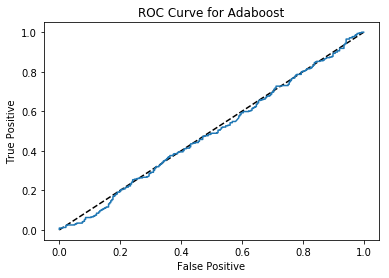

AUC using cross val: 
	[0.49816716 0.44021739 0.48643761 0.50487013]

 Mean AUC score is: 0.4824230724048973


In [41]:
# Generating the ROC curve
num_folds = 4
y_pred_proba = model_adb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive')
pyplot.ylabel('True Positive')
pyplot.title('ROC Curve for Adaboost')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_adb, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: \n\t" + str(auc_score))
mean_auc = np.mean(auc_score)
print("\n Mean AUC score is: " + str(mean_auc))

roc auc is :0.47736857535914845


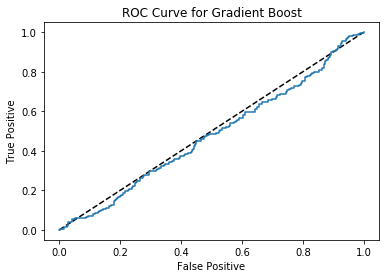

AUC using cross val: 
[0.42595308 0.4682971  0.44213382 0.46663059]


 Mean AUC score is: 0.4507536469525724


In [42]:
# Generating the ROC curve
y_pred_proba = model_gbc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive')
pyplot.ylabel('True Positive')
pyplot.title('ROC Curve for Gradient Boost')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_gbc, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: \n" + str(auc_score))
mean_auc = np.mean(auc_score)
print("\n\n Mean AUC score is: " + str(mean_auc))

roc auc is :0.490995917999143


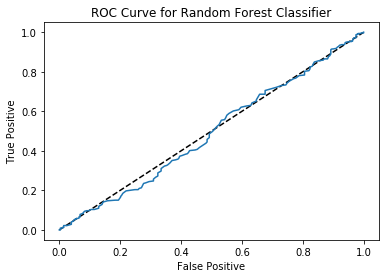

AUC using cross val: 
[0.43365103 0.49121377 0.46075949 0.48385642]


 Mean AUC score is: 0.46737017738405284


In [43]:
# Generating the ROC curve
y_pred_proba = model_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive')
pyplot.ylabel('True Positive')
pyplot.title('ROC Curve for Random Forest Classifier')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_rf, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: \n" + str(auc_score))
mean_auc = np.mean(auc_score)
print("\n\n Mean AUC score is: " + str(mean_auc))

### Hyper paramtere Tuning for Gradient Boost, AdaBoost and Random Forest

In [44]:
from sklearn.model_selection import GridSearchCV
import matplotlib

matplotlib.use('Agg')
n_estimators = [150, 200, 350, 400, 550, 700]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = GradientBoostingClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score = " + str(score) + " depth = " + str(md) + " estimator = " + str(n))
print("\n\nResult : Score = " + str(max_score) + " depth = " + str(best_depth) + " estimator = " + str(best_estimator))

Score = 0.5460636515912898 depth = 1 estimator = 150
Score = 0.5376884422110553 depth = 2 estimator = 150
Score = 0.5510887772194305 depth = 3 estimator = 150
Score = 0.5226130653266332 depth = 4 estimator = 150
Score = 0.5192629815745393 depth = 5 estimator = 150
Score = 0.49413735343383586 depth = 6 estimator = 150
Score = 0.5125628140703518 depth = 7 estimator = 150
Score = 0.509212730318258 depth = 8 estimator = 150
Score = 0.52428810720268 depth = 9 estimator = 150
Score = 0.49748743718592964 depth = 10 estimator = 150
Score = 0.49246231155778897 depth = 11 estimator = 150
Score = 0.5343383584589615 depth = 1 estimator = 200
Score = 0.5393634840871022 depth = 2 estimator = 200
Score = 0.5460636515912898 depth = 3 estimator = 200
Score = 0.5159128978224455 depth = 4 estimator = 200
Score = 0.5058626465661642 depth = 5 estimator = 200
Score = 0.49246231155778897 depth = 6 estimator = 200
Score = 0.5192629815745393 depth = 7 estimator = 200
Score = 0.52428810720268 depth = 8 estimato

In [45]:
from sklearn import tree

crossvalidation=KFold(n_splits=10,shuffle=True,random_state=42)

for depth in range (1,10):
    tree_classifier=tree.DecisionTreeClassifier(max_depth=depth,random_state=1)
    if tree_classifier.fit(X_train,y_train).tree_.max_depth<depth:
        break
    score=np.mean(cross_val_score(tree_classifier,X_train,y_train,scoring='accuracy', cv=crossvalidation,n_jobs=1))
    print(depth, score)

1 0.5248098663926003
2 0.5176156217882837
3 0.514737923946557
4 0.5133093525179856
5 0.5046813977389517
6 0.5017882836587872
7 0.5075436793422405
8 0.480955806783145
9 0.50103802672148


In [46]:
ada=AdaBoostClassifier()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}
tuned_ada=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='accuracy',n_jobs=1,cv=crossvalidation)

In [47]:
tuned_ada.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 1000, 2000], 'learning_rate': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [48]:
tuned_ada.best_params_

{'learning_rate': 0.001, 'n_estimators': 500}

In [49]:
tuned_ada.best_score_

0.5240833932422717

In [50]:
grid={"C":[2,1,0.1,0.01], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,n_jobs =-1,cv=3)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1'}
accuracy : 0.5363048166786485


In [51]:
logreg2=LogisticRegression(C=0.001, penalty = 'l2')
logreg2.fit(X_train,y_train)
print("score",logreg2.score(X_test,y_test))

score 0.5343383584589615


In [52]:
logreg3=LogisticRegression(C=1, penalty = 'l2')
logreg3.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accu_score = accuracy_score(y_test, y_pred)
print(accu_score)

0.509212730318258


In [53]:
    clf = LogisticRegression(C=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

KNN: 0.5527638190954773


## Hyptertuning using Pipeline
Below is a pipeline using a logistic regression

In [54]:
# Split the dataframe for Labels and Target
X = df3.loc[:,'Subjectivity':'change_3day_Trend']
y = df3.loc[:,'Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

parameteres = {'Logistic__C':[2,1,0.1,0.01], 'Logistic__penalty':["l1","l2"]}

#grid={"C":[2,1,0.1,0.01], "penalty":["l1","l2"]}
pipe = Pipeline([('imputer', Imputer(strategy = 'median'))
               , ('ScalerBob',preprocessing.MinMaxScaler())
               , ('Logistic', LogisticRegression())])

grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)

#tuned_log=GridSearchCV(pipe,param_grid=grid,scoring='accuracy',n_jobs=1,cv=crossvalidation)

In [56]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('ScalerBob', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'Logistic__C': [2, 1, 0.1, 0.01], 'Logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
print(grid.best_params_)
print(grid.best_score_)

{'Logistic__C': 0.1, 'Logistic__penalty': 'l1'}
0.5363048166786485
